# Training the ConvNP Model 

In this notebook, we will preprocess Great Lakes data using an existing data processor, generate tasks for model training, and set up a training loop to train a **ConvNP** model using DeepSensor. We will:
1. Load and preprocess temporal and static datasets like **SST**, **Ice Concentration**, **Lake Mask**, and **Bathymetry**.
2. Load and use an existing **DataProcessor** to handle data normalization.
3. Generate tasks using **TaskLoader** and train the **ConvNP** model.
4. Monitor validation performance and track model training losses and RMSE (Root Mean Squared Error).

Let's begin by importing necessary packages and defining helper functions.


## Step 1: Import Packages and Define Helper Functions

We import the libraries required for:
- Data manipulation and visualization (`xarray`, `pandas`, `matplotlib`).
- Geospatial operations (`cartopy`).
- Efficient computation with Dask (`dask`).
- DeepSensor for data processing and model training (`deepsensor`).

Additionally, we import local helper functions such as `standardize_dates`, which standardizes the 'time' dimension in the dataset to a date-only format (`datetime64[D]`). We also define `generate_random_coordinates` and custom save and load functions, as the default functions in DeepSensor appear to be broken in this environment. 


In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import dask.array as da
import gcsfs
import os

import deepsensor.torch
from deepsensor.data import DataProcessor, TaskLoader, construct_circ_time_ds
from deepsensor.data.sources import get_era5_reanalysis_data, get_earthenv_auxiliary_data, \
    get_gldas_land_mask
from deepsensor.model import ConvNP
from deepsensor.train import Trainer, set_gpu_default_device

# Local package utilities
from deepsensor_greatlakes.utils import standardize_dates, generate_random_coordinates, apply_mask_to_prediction
from deepsensor_greatlakes.preprocessor import SeasonalCycleProcessor, list_saved_seasonal_cycles
from deepsensor_greatlakes.model import save_model, load_convnp_model

In [2]:
set_gpu_default_device()

## Step 2: Data Inventory and Preprocessing

In this section, we load the required environmental datasets for model training:
- **Ice Concentration**: A dataset of ice cover over time in the Great Lakes.
- **GLSEA (Sea Surface Temperature)**: A dataset of sea surface temperature.
- **Bathymetry**: A dataset representing the underwater topography of the lakes.
- **Lake Mask**: A binary mask indicating water presence.

These datasets are loaded from storage and preprocessed by converting time into date-only format and handling missing data.


### User Inputs - Select Training and Validation Ranges

In [3]:
# Training/data config (adapted for Great Lakes)
#data_range = ("2009-01-01", "2022-12-31")
#train_range = ("2009-01-01", "2021-12-31")
#val_range = ("2022-01-01", "2022-12-31")
#date_subsample_factor = 10

# Just two years for demo purposes
data_range = ("2009-01-01", "2010-12-31")
train_range = ("2009-01-01", "2009-12-31")
val_range = ("2010-01-01", "2010-12-31")
date_subsample_factor = 30

In [4]:
# Path to the Zarr stores (NOTE: This won't work on U-M HPC. Paths must be changed)
#bathymetry_path = 'gs://great-lakes-osd/context/interpolated_bathymetry.nc'
#mask_path = 'gs://great-lakes-osd/context/lakemask.nc'
#ice_concentration_path = 'gs://great-lakes-osd/ice_concentration.zarr'
#glsea_path = 'gs://great-lakes-osd/GLSEA_combined.zarr'
#glsea3_path = 'gs://great-lakes-osd/GLSEA3_combined.zarr'

# Path to the files on U-M HPC
bathymetry_path = '/nfs/turbo/seas-dannes/SST-sensor-placement-input/bathymetry/interpolated_bathymetry.nc'
mask_path = '/nfs/turbo/seas-dannes/SST-sensor-placement-input/masks/lakemask.nc'
ice_concentration_path = '/nfs/turbo/seas-dannes/SST-sensor-placement-input/ice_concentration_processed.zarr'
glsea_path = '/nfs/turbo/seas-dannes/SST-sensor-placement-input/glsea_anom_processed.zarr'
glsea_raw_path = '/nfs/turbo/seas-dannes/SST-sensor-placement-input/GLSEA3_combined.zarr'

# Paths to saved configurations
deepsensor_folder = '../deepsensor_config/'

## Step 3: Loading Temporal Datasets (Ice Concentration and GLSEA)

In this section, we load the **Ice Concentration** and **GLSEA** datasets stored in Zarr format. These datasets contain critical temporal information on ice cover and sea surface temperature.

We perform the following preprocessing:
1. Replace invalid land values (denoted by `-1`) with `NaN`.
2. Standardize the time dimension to date-only precision.
3. Drop unnecessary variables like **CRS**.

Let’s load and preprocess the data now.


In [5]:
# Open the Zarr stores
ice_concentration = xr.open_zarr(ice_concentration_path)
glsea = xr.open_zarr(glsea_path)
glsea_raw = xr.open_zarr(glsea_raw_path)

# Replace -1 (land value) with NaN
ice_concentration = ice_concentration.where(ice_concentration != -1, float('nan'))

# Convert all times to date-only format, removing the time component
ice_concentration = standardize_dates(ice_concentration)
glsea = standardize_dates(glsea)
glsea_raw = standardize_dates(glsea_raw)
#glsea3 = standardize_dates(glsea3

## Step 4: Loading Static Datasets (Bathymetry and Lake Mask)

Next, we load two static datasets:
- **Bathymetry**: The underwater features of the Great Lakes.
- **Lake Mask**: A binary mask indicating water bodies within the lakes.

These datasets are loaded from NetCDF files and undergo basic preprocessing. 


In [6]:
# Open the NetCDF files using xarray 
bathymetry_raw = xr.open_dataset(bathymetry_path)
lakemask_raw = xr.open_dataset(mask_path)

# Name the bathymetry variable (only needed if reading from GCP)
#bathymetry_raw = bathymetry_raw.rename({'__xarray_dataarray_variable__': 'bathymetry'})

## Step 5: Initialize the Data Processor

The **DataProcessor** from DeepSensor is used to preprocess and normalize the datasets, getting them ready for model training. It applies scaling and transformation techniques to the datasets, such as **min-max scaling**.

We initialize the **DataProcessor** and apply it to the datasets. Below we load the `data_processor` that we fit in the last notebook. 


In [7]:
#data_processor = DataProcessor(deepsensor_folder)
data_processor = DataProcessor(os.path.join(deepsensor_folder, "data_processor"))
print(data_processor)

DataProcessor with normalisation params:
{'coords': {'time': {'name': 'time'},
            'x1': {'map': (38.8749871947229, 55.4132976408956), 'name': 'lat'},
            'x2': {'map': (-92.4199507342304, -75.8816402880577),
                   'name': 'lon'}},
 'ice_concentration': {'method': 'min_max', 'params': {'max': 1.0, 'min': 0.0}},
 'sst_anom': {'method': 'mean_std',
              'params': {'mean': 3.6779758829652565e-06,
                         'std': 2.022264242172241}}}


In [8]:
glsea

<xarray.Dataset> Size: 40GB
Dimensions:   (time: 10221, x1: 838, x2: 1181)
Coordinates:
    month     (time) int64 82kB dask.array<chunksize=(10221,), meta=np.ndarray>
  * time      (time) datetime64[s] 82kB 1995-01-01 1995-01-02 ... 2022-12-31
  * x1        (x1) float64 7kB 0.0 0.0008475 0.001695 ... 0.7076 0.7085 0.7093
  * x2        (x2) float64 9kB 0.0 0.0008475 0.001695 ... 0.9983 0.9992 1.0
Data variables:
    sst_anom  (time, x1, x2) float32 40GB dask.array<chunksize=(320, 53, 74), meta=np.ndarray>

In [9]:
# process the bathymetry and lake
bathymetry, lakemask = data_processor([bathymetry_raw, lakemask_raw], method="min_max")

In [10]:
data_processor.config

{'coords': {'time': {'name': 'time'},
  'x1': {'name': 'lat', 'map': (38.8749871947229, 55.4132976408956)},
  'x2': {'name': 'lon', 'map': (-92.4199507342304, -75.8816402880577)}},
 'sst_anom': {'method': 'mean_std',
  'params': {'mean': 3.6779758829652565e-06, 'std': 2.022264242172241}},
 'ice_concentration': {'method': 'min_max',
  'params': {'min': 0.0, 'max': 1.0}},
 'bathymetry': {'method': 'min_max',
  'params': {'min': 9.999999999999998, 'max': 316.62872313037894}},
 'mask': {'method': 'min_max', 'params': {'min': 0.0, 'max': 1.0}}}

In [11]:
dates = pd.date_range(glsea.time.values.min(), glsea.time.values.max(), freq="D")
dates = pd.to_datetime(dates).normalize()  # This will set all times to 00:00:00

In [12]:
doy_ds = construct_circ_time_ds(dates, freq="D")
cos_D = standardize_dates(doy_ds["cos_D"])
sin_D = standardize_dates(doy_ds["sin_D"])
print(cos_D)
print(sin_D)

<xarray.DataArray 'cos_D' (time: 10227)> Size: 82kB
array([0.999852, 0.999408, 0.998669, ..., 0.999251, 0.999769, 0.999991])
Coordinates:
  * time     (time) datetime64[s] 82kB 1995-01-01 1995-01-02 ... 2022-12-31
<xarray.DataArray 'sin_D' (time: 10227)> Size: 82kB
array([ 0.017202,  0.034398,  0.051584, ..., -0.038696, -0.021501, -0.004301])
Coordinates:
  * time     (time) datetime64[s] 82kB 1995-01-01 1995-01-02 ... 2022-12-31


In [38]:
bathymetry["bathymetry"]

<xarray.DataArray 'bathymetry' (x1: 240, x2: 360)> Size: 691kB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * x1       (x1) float64 2kB 0.1523 0.1542 0.1561 ... 0.5958 0.5976 0.5995
  * x2       (x2) float64 3kB 0.02107 0.02375 0.02642 ... 0.9765 0.9791 0.9818

In [37]:
lakemask["mask"]

<xarray.DataArray 'mask' (x1: 838, x2: 1181)> Size: 4MB
array([[-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       ...,
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.]], dtype=float32)
Coordinates:
  * x1       (x1) float64 7kB 0.0 0.0008475 0.001695 ... 0.7076 0.7085 0.7093
  * x2       (x2) float64 9kB 0.0 0.0008475 0.001695 ... 0.9983 0.9992 1.0

## Step 6: Generating Random Coordinates within the Lake Mask

We generate random coordinates within the **lake mask**. These coordinates represent sampling points inside the Great Lakes region. The **DataProcessor** is used to normalize these coordinates, ensuring that they are suitable for training the model.

We will generate `N` random coordinates and plot them to visualize their distribution within the lake.


In [13]:
# Example usage
N = 100  # Number of random points
random_lake_points = generate_random_coordinates(lakemask_raw, N, data_processor)

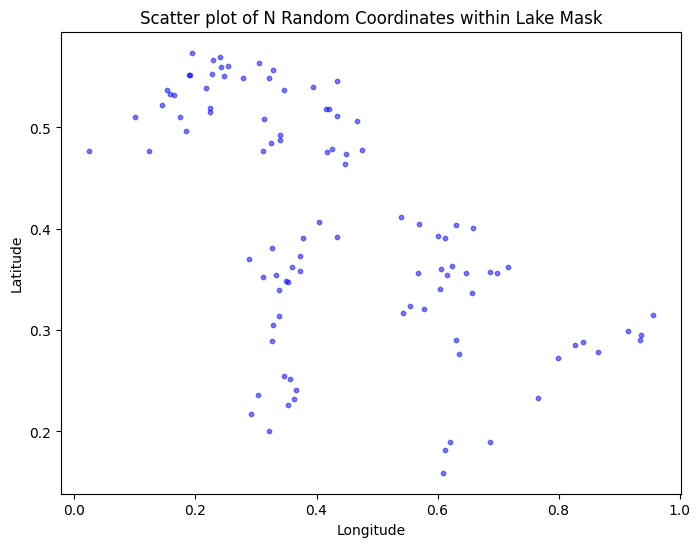

In [14]:
import matplotlib.pyplot as plt

# Assuming random_coords is the (2, N) array from the previous step
latitudes = random_lake_points[0, :]
longitudes = random_lake_points[1, :]

# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(longitudes, latitudes, color='blue', alpha=0.5, s=10)
plt.title("Scatter plot of N Random Coordinates within Lake Mask")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


## Step 7: Task Generation for Model Training

In this section, we use **TaskLoader** to generate tasks. A task consists of context data (input features like sea surface temperature, bathymetry, etc.) and target data (what we want the model to predict, such as ice concentration).

We generate tasks for training by sampling from the datasets. Each task represents a training example that the model will learn from.


In [15]:
# Make auxiliary context dataset
aux_ds = xr.Dataset({
    "lakemask": lakemask["mask"],
    "bathymetry": bathymetry["bathymetry"],
    "cos_D": cos_D,
    "sin_D": sin_D,
})

# Initialize task loader
task_loader = TaskLoader(
    context = [glsea, ice_concentration, aux_ds],
    target = glsea,
)

In [16]:
task_loader

TaskLoader(3 context sets, 1 target sets)
Context variable IDs: (('sst_anom',), ('ice_concentration',), ('lakemask', 'bathymetry', 'cos_D', 'sin_D'))
Target variable IDs: (('sst_anom',),)

Context data dimensions: (1, 1, 4)
Target data dimensions: (1,)

In [17]:
from tqdm import tqdm

# Function to generate tasks
def gen_tasks(dates, N=100, progress=True, lakemask_raw=None, data_processor=None):
    if lakemask_raw is None or data_processor is None:
        raise ValueError("You must pass both `lakemask_raw` and `data_processor`.")

    tasks = []
    for date in tqdm(dates, disable=not progress):
        # Generate a fresh set of random lake points for each date
        random_points = generate_random_coordinates(lakemask_raw, N, data_processor)
        
        # Sample the task
        task = task_loader(date, context_sampling=random_points, target_sampling="all")
        
        # Remove NaNs from the target
        task = task.remove_target_nans()
        
        tasks.append(task)
    
    return tasks


In [18]:
# Generate training and validation dates
train_dates = pd.date_range(train_range[0], train_range[1])[::date_subsample_factor]
val_dates = pd.date_range(val_range[0], val_range[1])[::date_subsample_factor]

# Normalize to datetime64[D]
train_dates = pd.to_datetime(train_dates).normalize()
val_dates = pd.to_datetime(val_dates).normalize()

# Generate training and validation tasks
train_tasks = gen_tasks(
    train_dates,
    N=100,  # or whatever number of lake points you want per task
    lakemask_raw=lakemask_raw,
    data_processor=data_processor
)

val_tasks = gen_tasks(
    val_dates,
    N=100,  # match N for validation, or use a different number if you want
    lakemask_raw=lakemask_raw,
    data_processor=data_processor
)


100%|██████████| 13/13 [00:15<00:00,  1.16s/it]


In [47]:
bathymetry_sample = train_tasks[2]["Y_c"][2][1]
print(bathymetry_sample.shape)
print(np.isnan(bathymetry_sample).sum())

(100,)
100


In [19]:
train_tasks[10]

time: Timestamp/2009-10-28 00:00:00
ops: ['str/target_nans_removed']
X_c: ['ndarray/float32/(2, 100)', 'ndarray/float32/(2, 100)', 'ndarray/float32/(2, 100)']
Y_c: ['ndarray/float32/(1, 100)', 'ndarray/float32/(1, 100)', 'ndarray/float32/(4, 100)']
X_t: ['ndarray/float32/(2, 139599)']
Y_t: ['ndarray/float32/(1, 139599)']

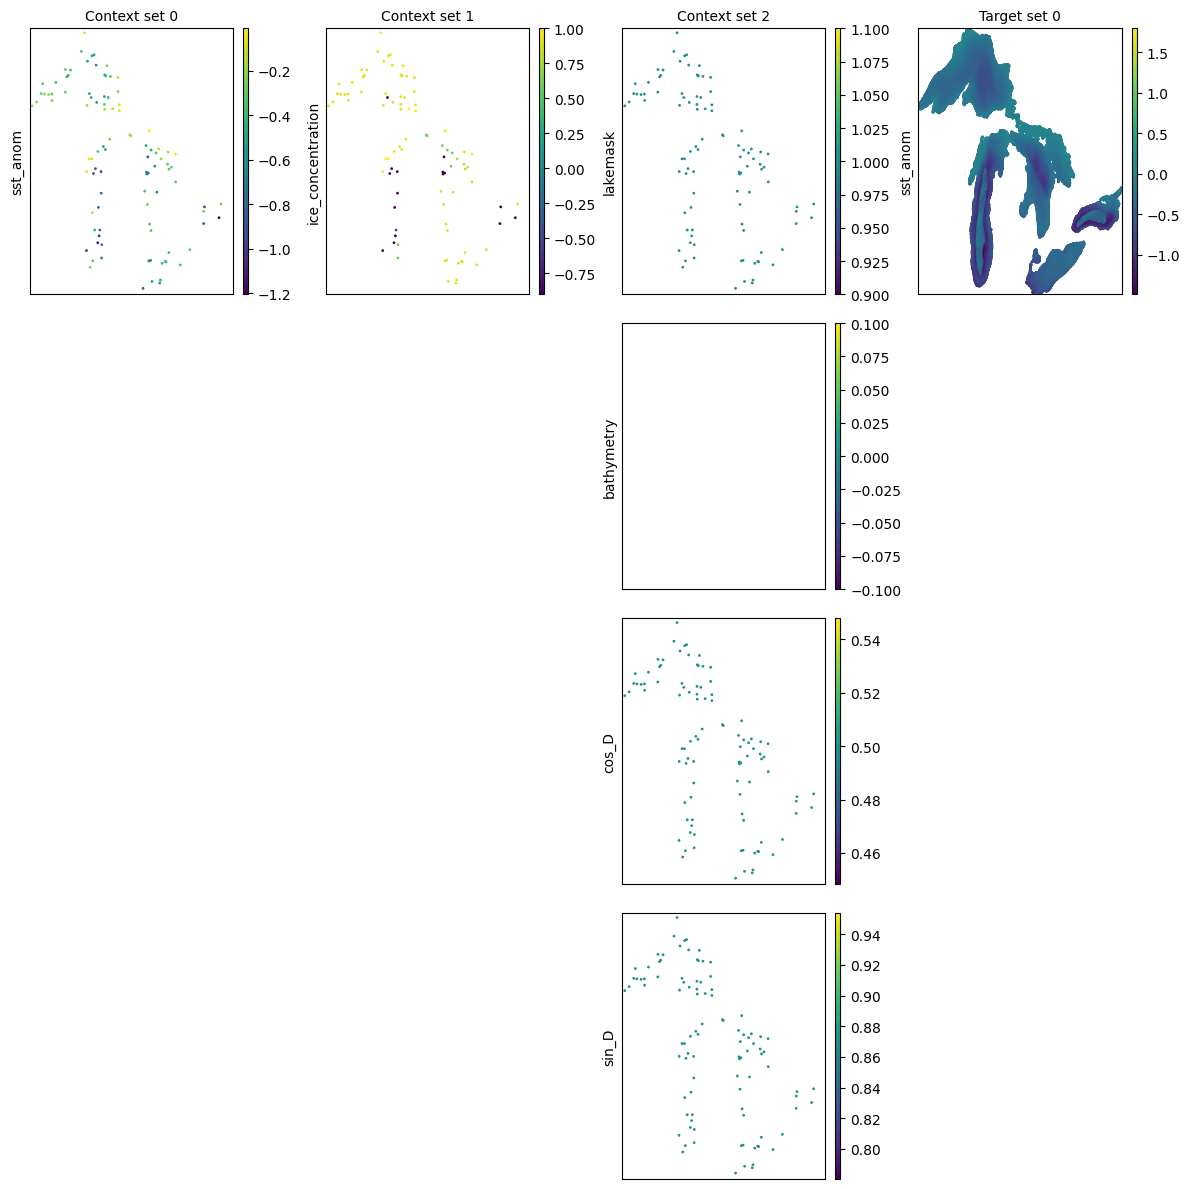

In [20]:
fig = deepsensor.plot.task(train_tasks[2], task_loader)
plt.show()

## Step 8: Model Setup and Training

We now set up the **ConvNP** model, a neural process-based model from **DeepSensor**. We use the **DataProcessor** and **TaskLoader** as inputs to the model, which allows the model to handle context and target data properly during training.

The model is then trained for a set number of epochs, and we monitor its performance by tracking the training loss and validation RMSE (Root Mean Squared Error).

At the end of the training loop, we save the best-performing model.


In [21]:
# Set up model
model = ConvNP(data_processor, task_loader)

dim_yc inferred from TaskLoader: (1, 1, 4)
dim_yt inferred from TaskLoader: 1
dim_aux_t inferred from TaskLoader: 0
internal_density inferred from TaskLoader: 1540
encoder_scales inferred from TaskLoader: [np.float32(0.0004237288), np.float32(0.0004237288), np.float32(0.00032467532)]
decoder_scale inferred from TaskLoader: 0.0006493506493506494


In [22]:
# Define the Trainer and training loop
trainer = Trainer(model, lr=5e-5)

In [23]:
import torch

# Monitor validation performance
def compute_val_rmse(model, val_tasks):
    errors = []
    target_var_ID = task_loader.target_var_IDs[0][0]  # assuming 1st target set and 1D
    
    for task in val_tasks:
        with torch.no_grad():
            mean = data_processor.map_array(model.mean(task), target_var_ID, unnorm=True)
            true = data_processor.map_array(task["Y_t"][0], target_var_ID, unnorm=True)
            
        errors.extend((mean - true) ** 2)
        torch.cuda.empty_cache()
        
    return np.sqrt(np.mean(np.concatenate(errors)))

Training Epochs:   0%|          | 0/50 [00:00<?, ?it/s]/home/dannes/venv_deepsensor/lib/python3.10/site-packages/lab/types.py:178: DeprecationWarning: numpy.core is deprecated and has been renamed to numpy._core. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numerictypes.
  for name in np.core.numerictypes.__all__ + ["bool"]:
Training Epochs: 100%|██████████| 50/50 [19:07<00:00, 22.94s/it]


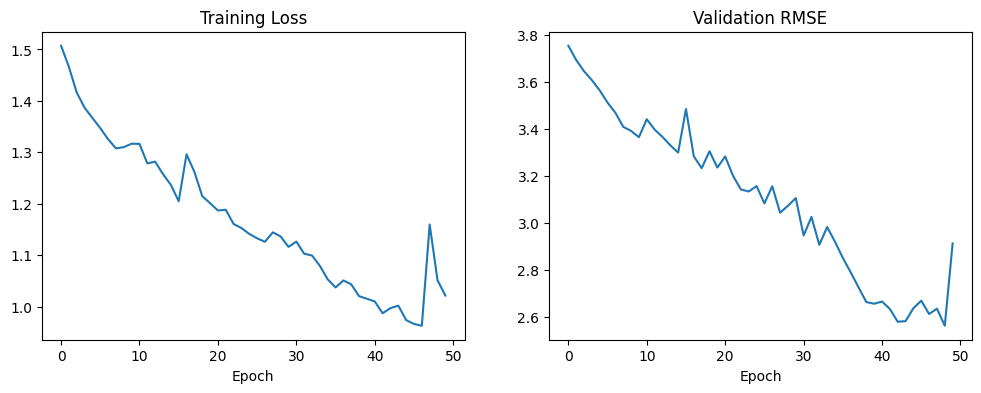

In [24]:
# Track the losses and validation RMSEs
losses = []
val_rmses = []
val_rmse_best = np.inf

# Start the training loop
for epoch in tqdm(range(50), desc="Training Epochs"):  # Training for 50 epochs
    # Generate tasks for training
    batch_losses = trainer(train_tasks)
    losses.append(np.mean(batch_losses))

    # Compute the validation RMSE
    val_rmse = compute_val_rmse(model, val_tasks)
    val_rmses.append(val_rmse)

    # Save the model if it performs better
    if val_rmse < val_rmse_best:
        val_rmse_best = val_rmse
        #model.save(deepsensor_folder)
        save_model(model, deepsensor_folder)

# Plot training losses and validation RMSE
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(losses)
axes[0].set_xlabel('Epoch')
axes[0].set_title('Training Loss')

axes[1].plot(val_rmses)
axes[1].set_xlabel('Epoch')
axes[1].set_title('Validation RMSE')

plt.show()


In [25]:
# To load it later:
# Assuming you have data_processor and task_loader instantiated in your notebook
loaded_model = load_convnp_model(deepsensor_folder, data_processor, task_loader)
print("Model loaded successfully with custom function!")

Attempting to instantiate ConvNP model (randomly initialized initially):
Architectural config for construct_neural_process (passed as **kwargs): {'dim_x': 2, 'dim_yc': [1, 1, 4], 'dim_yt': 1, 'dim_aux_t': 0, 'dim_lv': 0, 'conv_arch': 'unet', 'unet_channels': [64, 64, 64, 64], 'unet_resize_convs': True, 'unet_resize_conv_interp_method': 'bilinear', 'aux_t_mlp_layers': None, 'likelihood': 'het', 'unet_kernels': 5, 'internal_density': 1540, 'encoder_scales': [0.0004237288, 0.0004237288, 0.00032467532], 'encoder_scales_learnable': False, 'decoder_scale': 0.0006493506493506494, 'decoder_scale_learnable': False, 'num_basis_functions': 64, 'epsilon': 0.01}
Model loaded successfully with custom function!


## Step 9: Prediction

Now that we have a trained model, we can use it to make a prediction. Notice that we get both a mean and standard deviation from this prediciton. 

In [26]:
loaded_model = model

date = "2010-08-29"
test_task = task_loader(date, context_sampling=random_lake_points, target_sampling="all")
prediction_ds = loaded_model.predict(test_task, X_t=glsea_raw)
prediction_ds

{'sst_anom': <xarray.Dataset> Size: 8MB
 Dimensions:  (time: 1, lat: 838, lon: 1181)
 Coordinates:
   * lat      (lat) float64 7kB 38.87 38.89 38.9 38.92 ... 50.58 50.59 50.61
   * lon      (lon) float64 9kB -92.42 -92.41 -92.39 ... -75.91 -75.9 -75.88
   * time     (time) datetime64[ns] 8B 2010-08-29
 Data variables:
     mean     (time, lat, lon) float32 4MB -0.7241 -0.7241 ... -0.724 -0.724
     std      (time, lat, lon) float32 4MB 1.734 1.734 1.734 ... 1.734 1.734}

In [28]:
prediction_ds_masked = apply_mask_to_prediction(prediction_ds['sst_anom'], lakemask_raw)
prediction_ds_masked

<xarray.Dataset> Size: 8MB
Dimensions:  (time: 1, lat: 838, lon: 1181)
Coordinates:
  * lat      (lat) float64 7kB 38.87 38.89 38.9 38.92 ... 50.58 50.59 50.61
  * lon      (lon) float64 9kB -92.42 -92.41 -92.39 ... -75.91 -75.9 -75.88
  * time     (time) datetime64[ns] 8B 2010-08-29
Data variables:
    mean     (time, lat, lon) float32 4MB nan nan nan nan ... nan nan nan nan
    std      (time, lat, lon) float32 4MB nan nan nan nan ... nan nan nan nan

Note that the prediction produces both a mean prediction and a standard deviation, which is a characteristic of a Gaussian Process approach. 

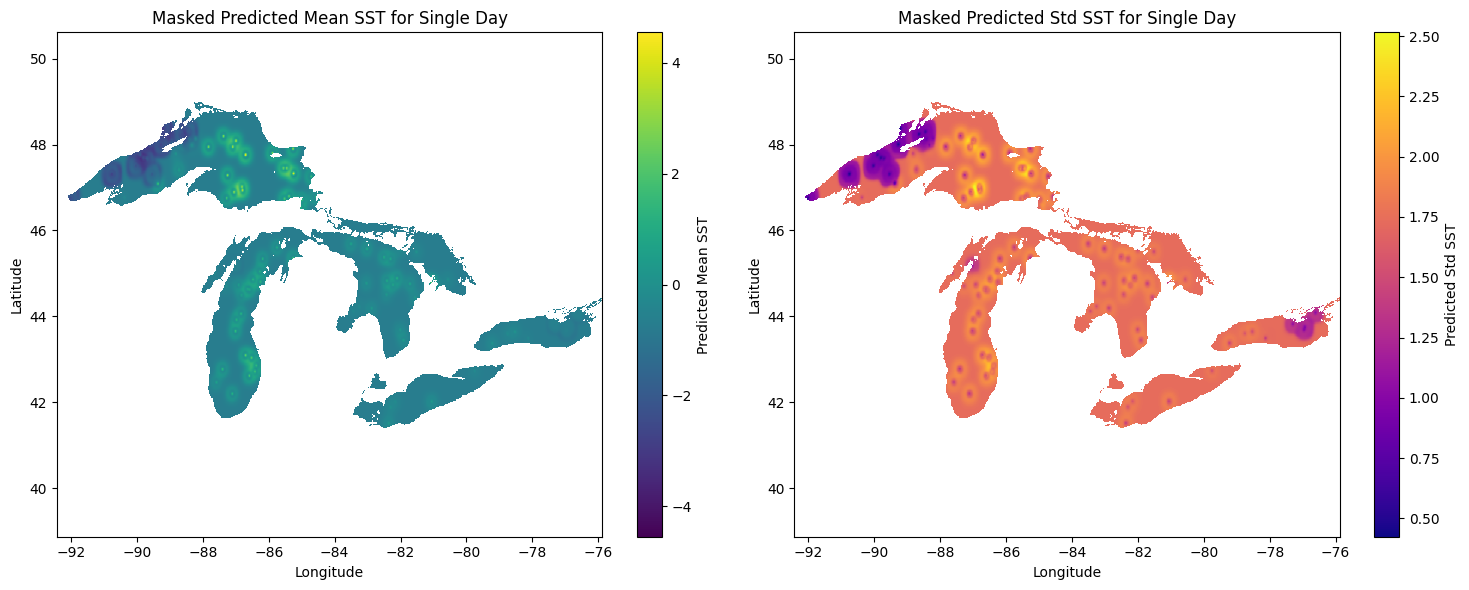

In [29]:
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
prediction_ds_masked['mean'].plot(cmap='viridis', cbar_kwargs={'label': 'Predicted Mean SST'})
plt.title(f'Masked Predicted Mean SST for Single Day')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.subplot(1, 2, 2) 
prediction_ds_masked['std'].plot(cmap='plasma', cbar_kwargs={'label': 'Predicted Std SST'})
plt.title(f'Masked Predicted Std SST for Single Day')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.tight_layout()
plt.show()

The above plot looks really bizarre because it has only been trained on two years of data! DeepSensor's models are data hungry...

# Conclusion

In this notebook, we:
1. Loaded and preprocessed several Great Lakes datasets for training a **ConvNP** model.
2. Generated tasks using **TaskLoader** and visualized data to perform sanity checks.
3. Trained the **ConvNP** model and monitored its performance.

Next, we will explore the active learning component of **DeepSensor**.
